## Obtain the last trained model and predict scores for 10k random variants

In [5]:
from sklearn.externals import joblib
from kipoi_cadd.data import CaddSparseDataset
from kipoi_cadd.utils import load_pickle, dump_to_pickle
from tqdm import tqdm
from math import log
from kipoi_cadd.utils import variant_id_string
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import cyvcf2
import numpy as np
import pandas as pd

In [16]:
training_dir = "/s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/"
model_file = "/tmp/gin-train/340a604cd72541ac957145df90687ebf/model.h5"
scaler_file = "/s/project/kipoi-cadd/data/models/CADD1.4-GRCh37.scaler"
sample_10k_ids_file = training_dir + "/variant_ids/sample_10k.pkl"
sample_10k_file = training_dir + "/sparse_matrices/sample_10k.npz"
vars_to_compare = training_dir + "sample_10k.vcf"
regions_txt = training_dir + "sample_10k_regions.txt"

In [2]:
kipoi_features_dir = "/s/project/kipoi-cadd/data/processed/v1.4/kipoi_features/GRCh37"
vars_to_compare = kipoi_features_dir + "vars_to_compare.vcf"
regions_txt = kipoi_features_dir + "regions.txt"
regions_output = kipoi_features_dir + "regions_output.vcf"

In [3]:
sample_10k_ids = load_pickle(sample_10k_ids_file)
sample_10k_ids.head()

1576330         2:67753726:G:['A']
4899162         5:42327270:T:['C']
17304765       10:83604667:A:['G']
1660556         2:82712968:T:['C']
32652416    5:49732570:A:['ATGCT']
dtype: object

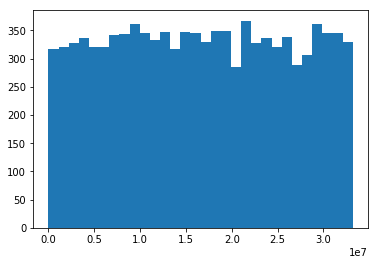

In [4]:
plt.hist(sample_10k_ids.index.values, bins=30);
plt.show()

### Load the model and the variants to be compared

In [10]:
clf = joblib.load(model_file)
scaler = joblib.load(scaler_file)
ds = CaddSparseDataset(sample_10k_file, sample_10k_ids_file, version="v1.4")
X, y = ds.load_all()

In [11]:
# Do the same process as the trainer
X_scaled = scaler.transform(X)

In [13]:
y_pred_kipoi = clf.predict(X)
y_pred_kipoi

array([1., 0., 0., ..., 1., 1., 0.], dtype=float32)

## Get VCF file for the selected variants

In [17]:
def variants_to_basic_vcf(variants, output_file=None, n_lines=None):
    vcf_string = ""
    for i, var in enumerate(variants):
        if isinstance(var, cyvcf2.Variant):
            vcf_string += var.CHROM + "\t" + var.POS + "\t" + var.ID + "\t" + var.REF + "\t" + var.ALT[0] + "\n"
        else:
            chrom, pos, ref, alt = var.split(":")
            vcf_string += chrom + "\t" + pos + "\tv" + str(i+1) + "\t" + ref + "\t" + alt.split("'")[1] + "\n"
        if n_lines is not None:
            if i >= n_lines: break

    if output_file is not None:
        with open(output_file, "w") as f:
            f.write(vcf_string)
        return None
    else:
        return vcf_string
    
def variants_to_basic_regions(variants, output_file=None, n_lines=None):
    region_df = {'CHROM': [], 'POS': [], 'REF': [], 'ALT': []}
    for i, var in enumerate(variants):
        if isinstance(var, cyvcf2.Variant):
            # region_string += var.CHROM + "\t" + var.POS + "\n"
            region_df['CHROM'].append(int(var.CHROM))
            region_df['POS'].append(int(var.POS))
            region_df['REF'].append(var.REF)
            region_df['ALT'].append(var.ALT[0])
        else:
            chrom, pos, ref, alt = var.split(":")
            # region_string += chrom + "\t" + pos + "\n"
            if chrom == 'X' or chrom == 'Y':
                region_df['CHROM'].append(chrom)                
            else:
                region_df['CHROM'].append(int(chrom))
            region_df['POS'].append(int(pos))
            region_df['REF'].append(ref)
            region_df['ALT'].append(alt.split("'")[1])
    
        if n_lines is not None:
            if i >= n_lines: break
    
    df = pd.DataFrame(region_df)
    df.sort_values(by=['CHROM', 'POS'], inplace=True)
    # df['region'] = [':'.join([str(r.CHROM), str(r.POS) + "-" + str(r.POS), "1/" + r.ALT]) for r in df.itertuples()]
    # SNP
    # 5:140532-140532:1/C
    if output_file is not None:
        # df.region.to_csv(output_file, sep='\t', index=None, header=None)
        df.to_csv(output_file, sep='\t', index=None, header=None)
        return None
    else:
        return df

variants_to_basic_regions(sample_10k_ids, regions_txt)
# variants_to_basic_vcf(sample_10k_ids, vars_to_compare)

Use this script:
``tabix -R /s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/sample_10k_regions.txt /s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/all.vcf.gz > /s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/sample_10k.vcf``

## a. Use CADD's package to get their scores
Used this command:
`./CADD.sh -g GRCh37 -o /s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/sample_10k.tsv.gz /s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/sample_10k.vcf`

In [18]:
cadd_vcf_output = training_dir + "sample_10k.tsv.gz"

In [25]:
cadd_scores = pd.read_csv(cadd_vcf_output, sep='\t', comment="#", header=None, names=['CHROM', 'POS', 'REF', 'ALT', 'CADD_RAW', 'CADD_PHRED'])
print(cadd_scores.shape)
cadd_scores.head()

(10095, 6)


,CHROM,POS,REF,ALT,CADD_RAW,CADD_PHRED
0,1,904778,T,C,0.003038,2.669
1,1,1211757,T,C,-1.025370,0.002
2,1,1343217,G,A,0.422567,8.626
3,1,1362172,A,G,0.005167,2.702
4,1,1880754,T,C,-0.279130,0.420


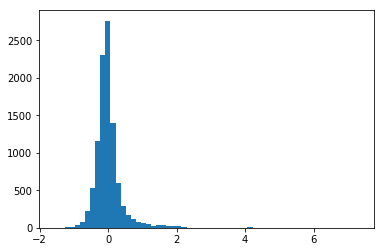

In [22]:
plt.hist(cadd_scores.CADD_RAW, bins=60);
plt.show()

In [23]:
print(cadd_scores.CADD_RAW.describe())
cadd_scores.shape[0]/3

count    10095.000000
mean         0.011406
std          0.436945
min         -1.561835
25%         -0.187923
50%         -0.043795
75%          0.104526
max          7.328400
Name: CADD_RAW, dtype: float64


3365.0

In [24]:
desired = pd.read_csv(regions_txt, sep='\t', header=None, names=['CHROM', 'POS', 'REF', 'ALT'])
desired.head()

,CHROM,POS,REF,ALT
0,1,904778,T,C
1,1,1211757,T,C
2,1,1343217,G,A
3,1,1362172,A,G
4,1,1846900,AA,A


In [26]:
found_vars = pd.merge(desired, cadd_scores, how='inner', on=['CHROM', 'POS', 'REF', 'ALT'])
print(found_vars.shape)

(9999, 6)


In [27]:
found_var_ids = [variant_id_string(r.CHROM, r.POS, r.REF, r.ALT) for r in found_vars.itertuples()]

In [29]:
found_var_nums = []
for found_var in tqdm(found_var_ids):
    for var_num, var_id in sample_10k_ids.items():
        if var_id == found_var:
            found_var_nums.append(var_num)

100%|██████████| 9999/9999 [00:37<00:00, 263.94it/s]


In [67]:
sample_10k_sorted_file = training_dir + "/sparse_matrices/sample_10k_sorted.npz"
sample_10k_ids_sorted_file = training_dir + "/variant_ids/sample_10k_sorted.pkl"
found_var_ids = pro_training_dir + "found_var_ids.pkl"
dump_to_pickle(found_var_ids, shuff_10k.loc[found_var_nums])

In [68]:
ds_found = CaddDataset(lmdb_dir, found_var_ids)
X_found, y_found = ds_found.load_all(shuffle=False)
# Do the same process as the trainer
X_sparse_found = csr_matrix(X_found, shape=None, dtype=np.float32, copy=True)
X_found = X_sparse_found
y_found = y_found.astype(np.float32)
del X_sparse_found

## Get log odd ratios of my scores
Obtain log odd ratios:
https://stats.idre.ucla.edu/stata/faq/how-do-i-interpret-odds-ratios-in-logistic-regression/

In [95]:
y_pred_kipoi_found = clf.predict_proba(X_found)
y_pred_kipoi_found = np.array([log(p[1]/p[0]) for p in y_pred_kipoi_found])

### b. 1. Calculate Pearson Correlation between my scores and theirs

In [100]:
from scipy.stats import pearsonr
pearsonr(y_pred_kipoi_found, found_vars.CADD_RAW)

(0.7764666974344197, 0.0)

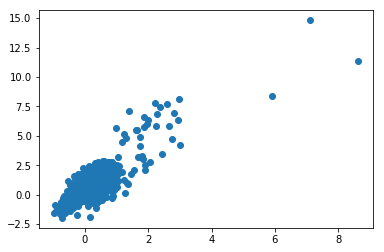

In [99]:
plt.scatter(y_pred_kipoi_found, found_vars.CADD_RAW);
plt.show()

## Evaluate accuracy by class

In [3]:
clf = joblib.load(model_file)
ds = CaddDataset(lmdb_dir, shuff_10k_file)
X, y = ds.load_all(shuffle=False)

# Do the same process as the trainer
X_sparse = csr_matrix(X, shape=None, dtype=np.float32, copy=True)
X = X_sparse
y = y.astype(np.float32)
del X_sparse

100%|██████████| 157/157 [00:00<00:00, 648.88it/s]


In [22]:
X_pos, y_pos = X[y.nonzero()[0],:], y[y.nonzero()[0]]
X_neg, y_neg = X[np.where(y == 0)[0]], y[np.where(y == 0)[0]]

In [24]:
score_pos = clf.score(X_pos, y_pos)
score_pos

0.5378680203045685

In [25]:
score_neg = clf.score(X_neg, y_neg)
score_neg

0.587192118226601